# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Fixed-variances" data-toc-modified-id="Fixed-variances-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fixed variances</a></div><div class="lev1 toc-item"><a href="#Sum-of-products,-freed-variances" data-toc-modified-id="Sum-of-products,-freed-variances-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sum of products, freed variances</a></div><div class="lev1 toc-item"><a href="#Sum-of-products,-all-parameters-free" data-toc-modified-id="Sum-of-products,-all-parameters-free-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sum of products, all parameters free</a></div><div class="lev1 toc-item"><a href="#STAN-Imputations" data-toc-modified-id="STAN-Imputations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>STAN Imputations</a></div><div class="lev1 toc-item"><a href="#Aggregating-MSE-over-all-windows" data-toc-modified-id="Aggregating-MSE-over-all-windows-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Aggregating MSE over all windows</a></div>

In [46]:
const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"

"/Volumes/Samsung250GB/temperature_model/saved"

In [47]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
import Mamba
using JLD
using Distances
using DataFrames: by, head
using Dates: tonext, Hour, Day

In [48]:
include("src/TempModel.jl")

TempModel

In [49]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [50]:
isdList=TempModel.read_isdList()
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

4×13 DataFrames.DataFrame
│ Row │ USAF   │ WBAN  │ NAME                             │ CTRY │ STATE │
├─────┼────────┼───────┼──────────────────────────────────┼──────┼───────┤
│ 1   │ 725450 │ 14990 │ THE EASTERN IOWA AIRPORT         │ US   │ IA    │
│ 2   │ 725460 │ 14933 │ DES MOINES INTERNATIONAL AIRPORT │ US   │ IA    │
│ 3   │ 725480 │ 94910 │ WATERLOO MUNICIPAL AIRPORT       │ US   │ IA    │
│ 4   │ 725485 │ 14940 │ MASON CITY MUNICIPAL ARPT        │ US   │ IA    │

│ Row │ ICAO │ LAT    │ LON     │ ELEV  │ BEGIN │ END  │ X_PRJ     │ Y_PRJ     │
├─────┼──────┼────────┼─────────┼───────┼───────┼──────┼───────────┼───────────┤
│ 1   │ KCID │ 41.883 │ -91.717 │ 264.6 │ 1973  │ 2015 │ 1.64799e6 │ 1.0441e6  │
│ 2   │ KDSM │ 41.534 │ -93.653 │ 291.7 │ 1973  │ 2015 │ 1.48723e6 │ 1.00379e6 │
│ 3   │ KALO │ 42.554 │ -92.401 │ 264.6 │ 1960  │ 2015 │ 1.59025e6 │ 1.11766e6 │
│ 4   │ KMCW │ 43.154 │ -93.327 │ 373.4 │ 1973  │ 2015 │ 1.51407e6 │ 1.18374e6 │

In [51]:
hourly_cat=TempModel.read_Stations(isdSubset)
itest=3
hourly_train = hourly_cat[hourly_cat[:station].values.!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].values.==itest,:]
nrow(hourly_train), nrow(hourly_test)
test_usaf=get(isdSubset[itest,:USAF])

725480

In [52]:
hr_measure = Hour(17) # number between 0 and 24
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts].values]
TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
    Tn=minimum(df[:temp].values), 
    Tx=maximum(df[:temp].values)))
test_trimmed=join(hourly_test, TnTx, on=:ts_day)
head(test_trimmed)

6×13 DataFrames.DataFrame
│ Row │ year │ month │ day │ hour │ min │ seconds │ temp  │
├─────┼──────┼───────┼─────┼──────┼─────┼─────────┼───────┤
│ 1   │ 2015 │ 1     │ 1   │ 0    │ 0   │ 0       │ -8.3  │
│ 2   │ 2015 │ 1     │ 1   │ 0    │ 54  │ 0       │ -8.9  │
│ 3   │ 2015 │ 1     │ 1   │ 1    │ 54  │ 0       │ -8.9  │
│ 4   │ 2015 │ 1     │ 1   │ 2    │ 54  │ 0       │ -9.4  │
│ 5   │ 2015 │ 1     │ 1   │ 3    │ 54  │ 0       │ -9.4  │
│ 6   │ 2015 │ 1     │ 1   │ 4    │ 54  │ 0       │ -10.0 │

│ Row │ ts                  │ station │ ts_hours │ ts_day     │ Tn    │ Tx   │
├─────┼─────────────────────┼─────────┼──────────┼────────────┼───────┼──────┤
│ 1   │ 2015-01-01T00:00:00 │ 3       │ 0.0      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 2   │ 2015-01-01T00:54:00 │ 3       │ 0.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 3   │ 2015-01-01T01:54:00 │ 3       │ 1.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 4   │ 2015-01-01T02:54:00 │ 3       │ 2.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 5   │ 2015-01-01T03:54:00 │ 3       │ 3.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 6   │ 2015-01-01T04:54:00 │ 3       │ 4.9      │ 2015-01-01 │ -11.1 │ -3.9 │

In [53]:
function subset(df, from, to; closed_start=true, closed_end=true)
    ts = df[:ts].values
    return df[argsubset(ts,from,to;closed_start=closed_start,closed_end=closed_end),:]
end
function argsubset(ts, from, to; closed_start=true, closed_end=true)
    if closed_start
        after_from = ts .>= from
    else
        after_from = ts .> from
    end
    if closed_end
        before_to = ts .<= to
    else
        before_to = ts .< to
    end
    return after_from & before_to
end

argsubset (generic function with 1 method)

In [54]:
function add_diag!(Σ::PDMats.PDMat, a::Float64)
    mat = Σ.mat
    for i in 1:size(mat,1)
        mat[i,i] += a
    end
    copy!(Σ.chol.factors, mat)
    cholfact!(Σ.chol.factors, Symbol(Σ.chol.uplo))
    @assert sumabs(mat .- full(Σ.chol)) < 1e-8
    return Σ
end
;

In [55]:
type FittingWindow
    start_date::Date
    end_date::Date
end

In [56]:
function predictions_fname(usaf::Int, fw::FittingWindow)
    return @sprintf("%d_%s_to_%s.jld", 
                    usaf, fw.start_date, fw.end_date)
end

function get_nearby(fw::FittingWindow, GPmodel::AbstractString)
    saved_dir = joinpath(SAVED_DIR, "predictions_from_nearby", GPmodel)
    pred_fname = predictions_fname(test_usaf, fw)
    nearby_pred=load(joinpath(saved_dir, pred_fname))["nearby_pred"]
end

get_nearby (generic function with 1 method)

In [57]:
function plot_predictive(nearby_pred::TempModel.NearbyPrediction, xlim::Tuple{DateTime,DateTime})
    test_subset = subset(test_trimmed, xlim[1], xlim[2])
    train_subset = subset(hourly_train, xlim[1], xlim[2])
    μ = nearby_pred.μ
    Σ = nearby_pred.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    for station in unique(train_subset[:station].values)
        sdata = train_subset[train_subset[:station].values.==station,:]
        ts=sdata[:ts].values
        plt.plot(ts, sdata[:temp].values.-mean(sdata[:temp].values), color="#F8A21F", 
            label="records at"get(isdSubset[station,:NAME]))
    end
    _ylim = plt.ylim()
    ts=nearby_pred.ts
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:2
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    plt.fill_between(ts, μ-2*√diag(Σ_centered),μ+2*√diag(Σ_centered), color="#009F77", alpha=0.3)
    ts = test_subset[:ts].values
    temp_true = test_subset[:temp].values
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
    plt.xlim(xlim)
    plt.ylim(_ylim)
end
;

In [58]:
function print_diagnostics(nearby::TempModel.NearbyPrediction; ndraws=10000)
    ts = nearby.ts
    ts_start = minimum(ts)
    ts_end = maximum(ts)
    test_subset = subset(test_trimmed, ts_start, ts_end)
    train_subset = subset(hourly_train, ts_start, ts_end)

    μ = nearby.μ
    Σ = nearby.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
#     println("sum(Σ_centered)=", sum(Σ_centered*Σ_centered))
    for _ in 1:5
        temp_sim = rand(distr)
        println("var(predicted mean - simulated prediction)=", var(μ .- temp_sim))
    end
    temp_true = test_subset[:temp].values
    println("E(var(predicted mean - predictive draw))=", mean(var(μ .- rand(distr)) for _ in 1:ndraws))
    println("var(truth - predicted mean)=", var(μ .- temp_true))
end

print_diagnostics (generic function with 2 methods)

In [59]:
function plot_residuals(nearby::TempModel.NearbyPrediction)
    ts = nearby.ts
    ts_start = minimum(ts)
    ts_end = maximum(ts)
    test_subset = subset(test_trimmed, ts_start, ts_end)

    μ = nearby_pred.μ
    Σ = nearby_pred.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    temp_true = test_subset[:temp].values
    println("var(truth - predicted mean)=", var(μ .- temp_true))
    residuals = μ .- temp_true
    plt.plot(ts, abs(residuals .- mean(residuals)))
    plt.ylabel("Absolute residuals")
end

plot_residuals (generic function with 2 methods)

# Fixed variances

In [60]:
test_fw = FittingWindow(Date(2015,4,8),Date(2015,6,20))

FittingWindow(2015-04-08,2015-06-20)

In [61]:
GPmodel="fixed_var"

"fixed_var"

In [62]:
nearby_pred = get_nearby(test_fw, GPmodel);

In [63]:
plot_predictive(nearby_pred, (DateTime(test_fw.start_date), DateTime(test_fw.end_date)))

LoadError: MethodError: objects of type ImputationDiagnostic are not callable

In [64]:
print_diagnostics(nearby_pred; ndraws=100)

var(predicted mean - simulated prediction)=9.606464417623117
var(predicted mean - simulated prediction)=10.948119107644525
var(predicted mean - simulated prediction)=9.468570717691481
var(predicted mean - simulated prediction)=8.320767262075606
var(predicted mean - simulated prediction)=10.127566605942441
E(var(predicted mean - predictive draw))=9.555700576612583
var(truth - predicted mean)=6.090607796619108


var(truth - predicted mean)=6

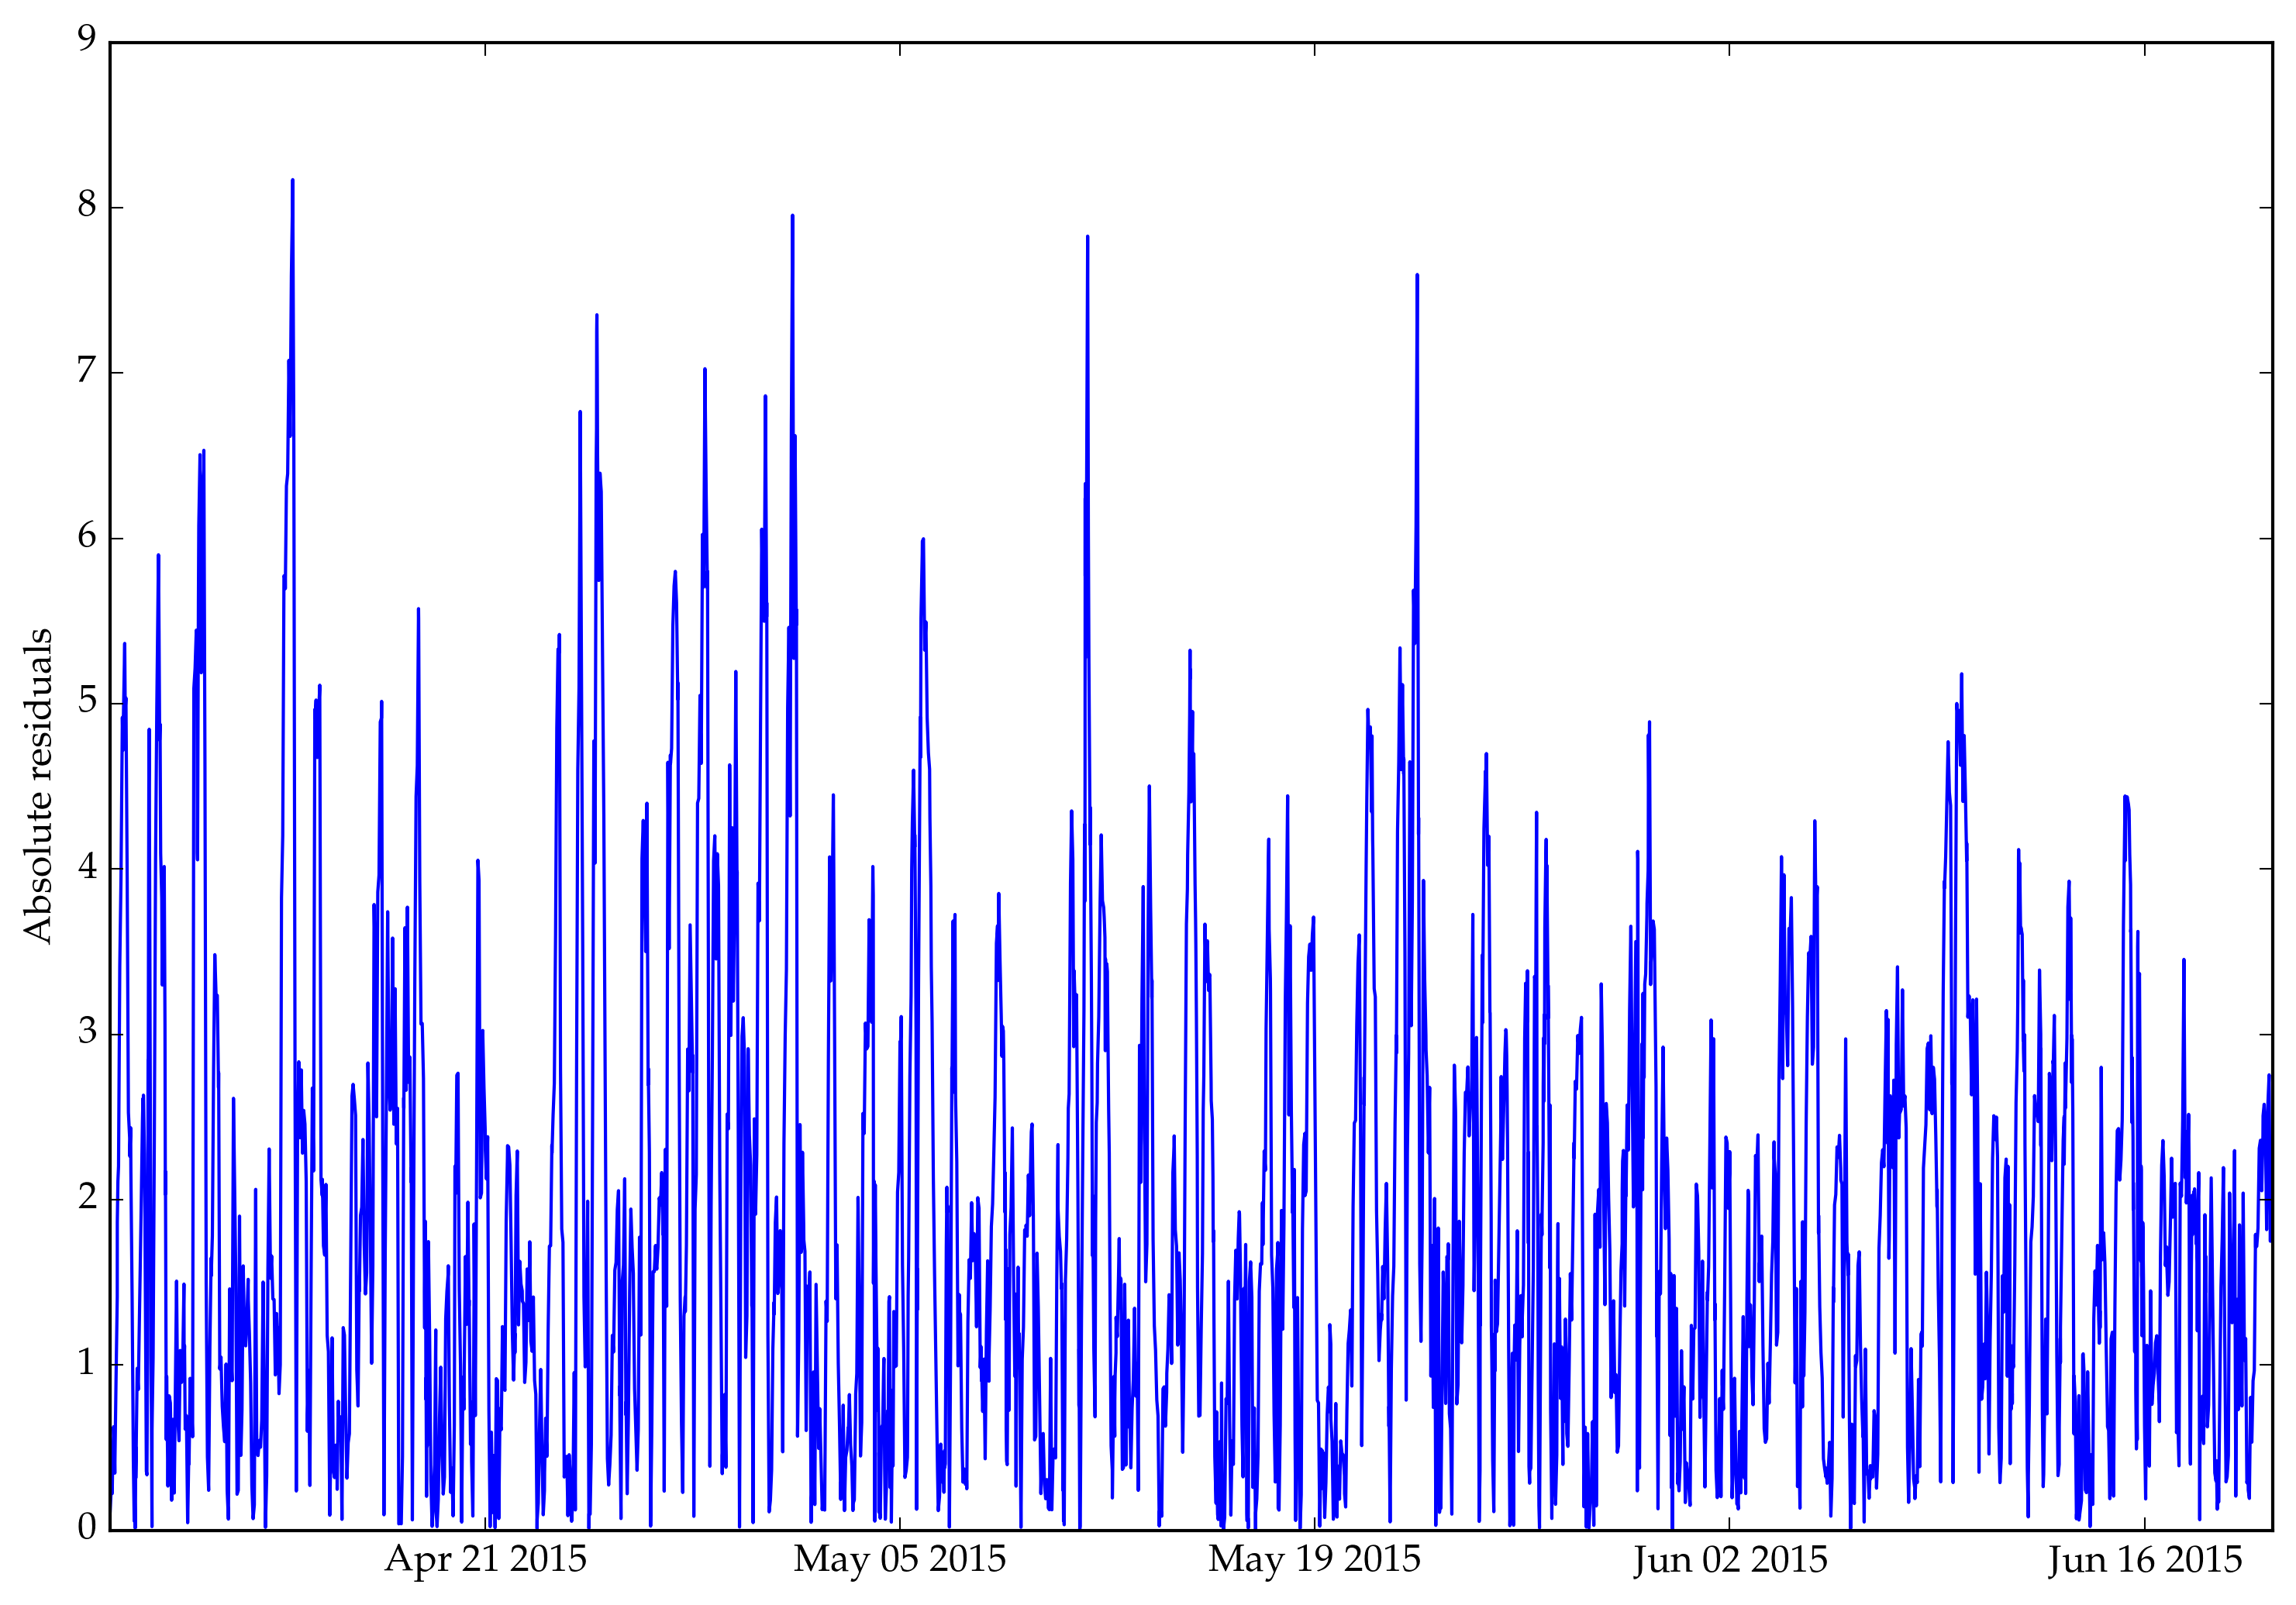

.090607796619108


PyObject <matplotlib.text.Text object at 0x3259103d0>

In [65]:
plot_residuals(nearby_pred)

In [66]:
plot_predictive(nearby_pred, (DateTime(2015,4,21),DateTime(2015,5,5)))

LoadError: MethodError: objects of type ImputationDiagnostic are not callable

# Sum of products, freed variances

In [67]:
GPmodel = "free_var"

"free_var"

In [68]:
nearby_pred = get_nearby(test_fw, GPmodel);

In [69]:
plot_predictive(nearby_pred, (DateTime(2015,4,21),DateTime(2015,5,5)))

LoadError: MethodError: objects of type ImputationDiagnostic are not callable

In [70]:
@time print_diagnostics(nearby_pred; ndraws=100)

var(predicted mean - simulated prediction)=2.3752364673178286
var(predicted mean - simulated prediction)=2.442534430086473
var(predicted mean - simulated prediction)=1.8776809459685664
var(predicted mean - simulated prediction)=2.219815683664355
var(predicted mean - simulated prediction)=3.0089047921212155
E(var(predicted mean - predictive draw))=2.4098577077311187
var(truth - predicted mean)=1.2494531076575177
  1.489054 seconds (10.20 k allocations: 312.270 MB, 28.09% gc time)


# Sum of products, all parameters free

In [71]:
GPmodel = "sumprod"

"sumprod"

In [72]:
nearby_pred = get_nearby(test_fw, GPmodel);

In [73]:
plot_predictive(nearby_pred, (DateTime(2015,4,21),DateTime(2015,5,5)))

LoadError: MethodError: objects of type ImputationDiagnostic are not callable

In [74]:
@time print_diagnostics(nearby_pred; ndraws=100)

var(predicted mean - simulated prediction)=2.016976621240174
var(predicted mean - simulated prediction)=2.083023207317982
var(predicted mean - simulated prediction)=1.6714120967093966
var(predicted mean - simulated prediction)=1.9219379783196153
var(predicted mean - simulated prediction)=1.8381497283758819
E(var(predicted mean - predictive draw))=1.7810135222113814
var(truth - predicted mean)=1.3771718160277167
  1.074900 seconds (10.26 k allocations: 312.252 MB, 26.51% gc time)


Annoyingly, we again see that even though this model has more free parameters, and the marginal likelihood was significantly lower (when we optimized all the parameters), the predictive variance is actually worse (higher).

# STAN Imputations

In [75]:
function stan_dirname(usaf::Int, fw::FittingWindow)
    return @sprintf("%d_%s_to_%s/", 
                    usaf, fw.start_date, fw.end_date)
end

stan_dirname (generic function with 1 method)

In [76]:
stan_increment = Day(3)
stan_days = Day(9)
janfirst = Date(2015,1,1)
;

In [77]:
function get_test_fw(test::DataFrame, fw::FittingWindow)
    window_start = DateTime(fw.start_date) + hr_measure
    window_end = DateTime(fw.end_date) + hr_measure
    return subset(test, window_start, window_end; closed_start=false)
end
function arg_test_fw(test::DataFrame, fw::FittingWindow)
    window_start = DateTime(fw.start_date) + hr_measure
    window_end = DateTime(fw.end_date) + hr_measure
    return argsubset(test[:ts].values, window_start, window_end; closed_start=false)
end
function get_window(windownum::Int)
    stan_start = janfirst + (windownum-1)*stan_increment
    stan_end = stan_start + stan_days
    stan_fw = FittingWindow(stan_start, stan_end)
    return stan_fw
end
function window_center(fw::FittingWindow, increment::Day)
    # this doesn't generalize
    return FittingWindow(fw.start_date+increment,fw.end_date-increment)
end

window_center (generic function with 1 method)

In [78]:
function get_chains(fw::FittingWindow, GPmodel::AbstractString)
    stan_fw_dir = stan_dirname(test_usaf, fw)
    stan_model_dir = joinpath(SAVED_DIR, "stan_fit", GPmodel)
    stan_window_files = readdir(joinpath(stan_model_dir, stan_fw_dir))
    samplefiles = [joinpath(stan_model_dir, stan_fw_dir, f) for 
        f in stan_window_files if 
        endswith(f,".csv")]
    global header
    all_samples=[]
    for sf in samplefiles
        samples, header = readcsv(sf, Float64; header=true)
        push!(all_samples, samples)
    end

    samples = cat(3, all_samples...)
    chains = Mamba.Chains(samples; start=1, thin=1, chains=[i for i in 1:4], names=vec(header))
    return chains
end

get_chains (generic function with 1 method)

In [79]:
# convenience function to extract the imputed temperatures
# from the Mamba Chains object
function get_temperatures_reparam(chains::Mamba.Chains)
    temp_varnames = [h for h in chains.names if startswith(h, "temp_impt.")]
    temp_samples=getindex(chains, :, temp_varnames, :).value
    return temp_samples
end

get_temperatures_reparam (generic function with 1 method)

In [80]:
function get_temp_percentiles(temp_impute)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    sorted_impute = sort(stacked_impute,1);
    nsamples=size(sorted_impute,1)
    # extract  10th and 90th percentiles
    # of the imputations
    imputed_10 = sorted_impute[div(nsamples,10), :]
    imputed_90 = sorted_impute[nsamples-div(nsamples,10), :]
    return imputed_10, imputed_90
end
function get_temp_mean(temp_impute)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    μ = vec(mean(stacked_impute, 1))
    return μ
end

get_temp_mean (generic function with 1 method)

In [81]:
function plot_imputations(ts, temp_impute)
    imputed_10, imputed_90 = get_temp_percentiles(temp_impute)
    μ = get_temp_mean(temp_impute)
    
    plt.fill_between(ts, imputed_10, imputed_90, 
        color="#F16424", alpha=0.5, label=L"$80\%$ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    plt.plot(ts, μ, color="#F16424", linewidth=3, label="posterior mean")
end
function plot_truth(test::DataFrame)
    ts = test[:ts].values
    plt.plot(ts, test[:temp].values, 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subsubset[:Tn].values, 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subsubset[:Tx].values, 
        color="red", linewidth=3, label=L"$T_x$")
end

plot_truth (generic function with 1 method)

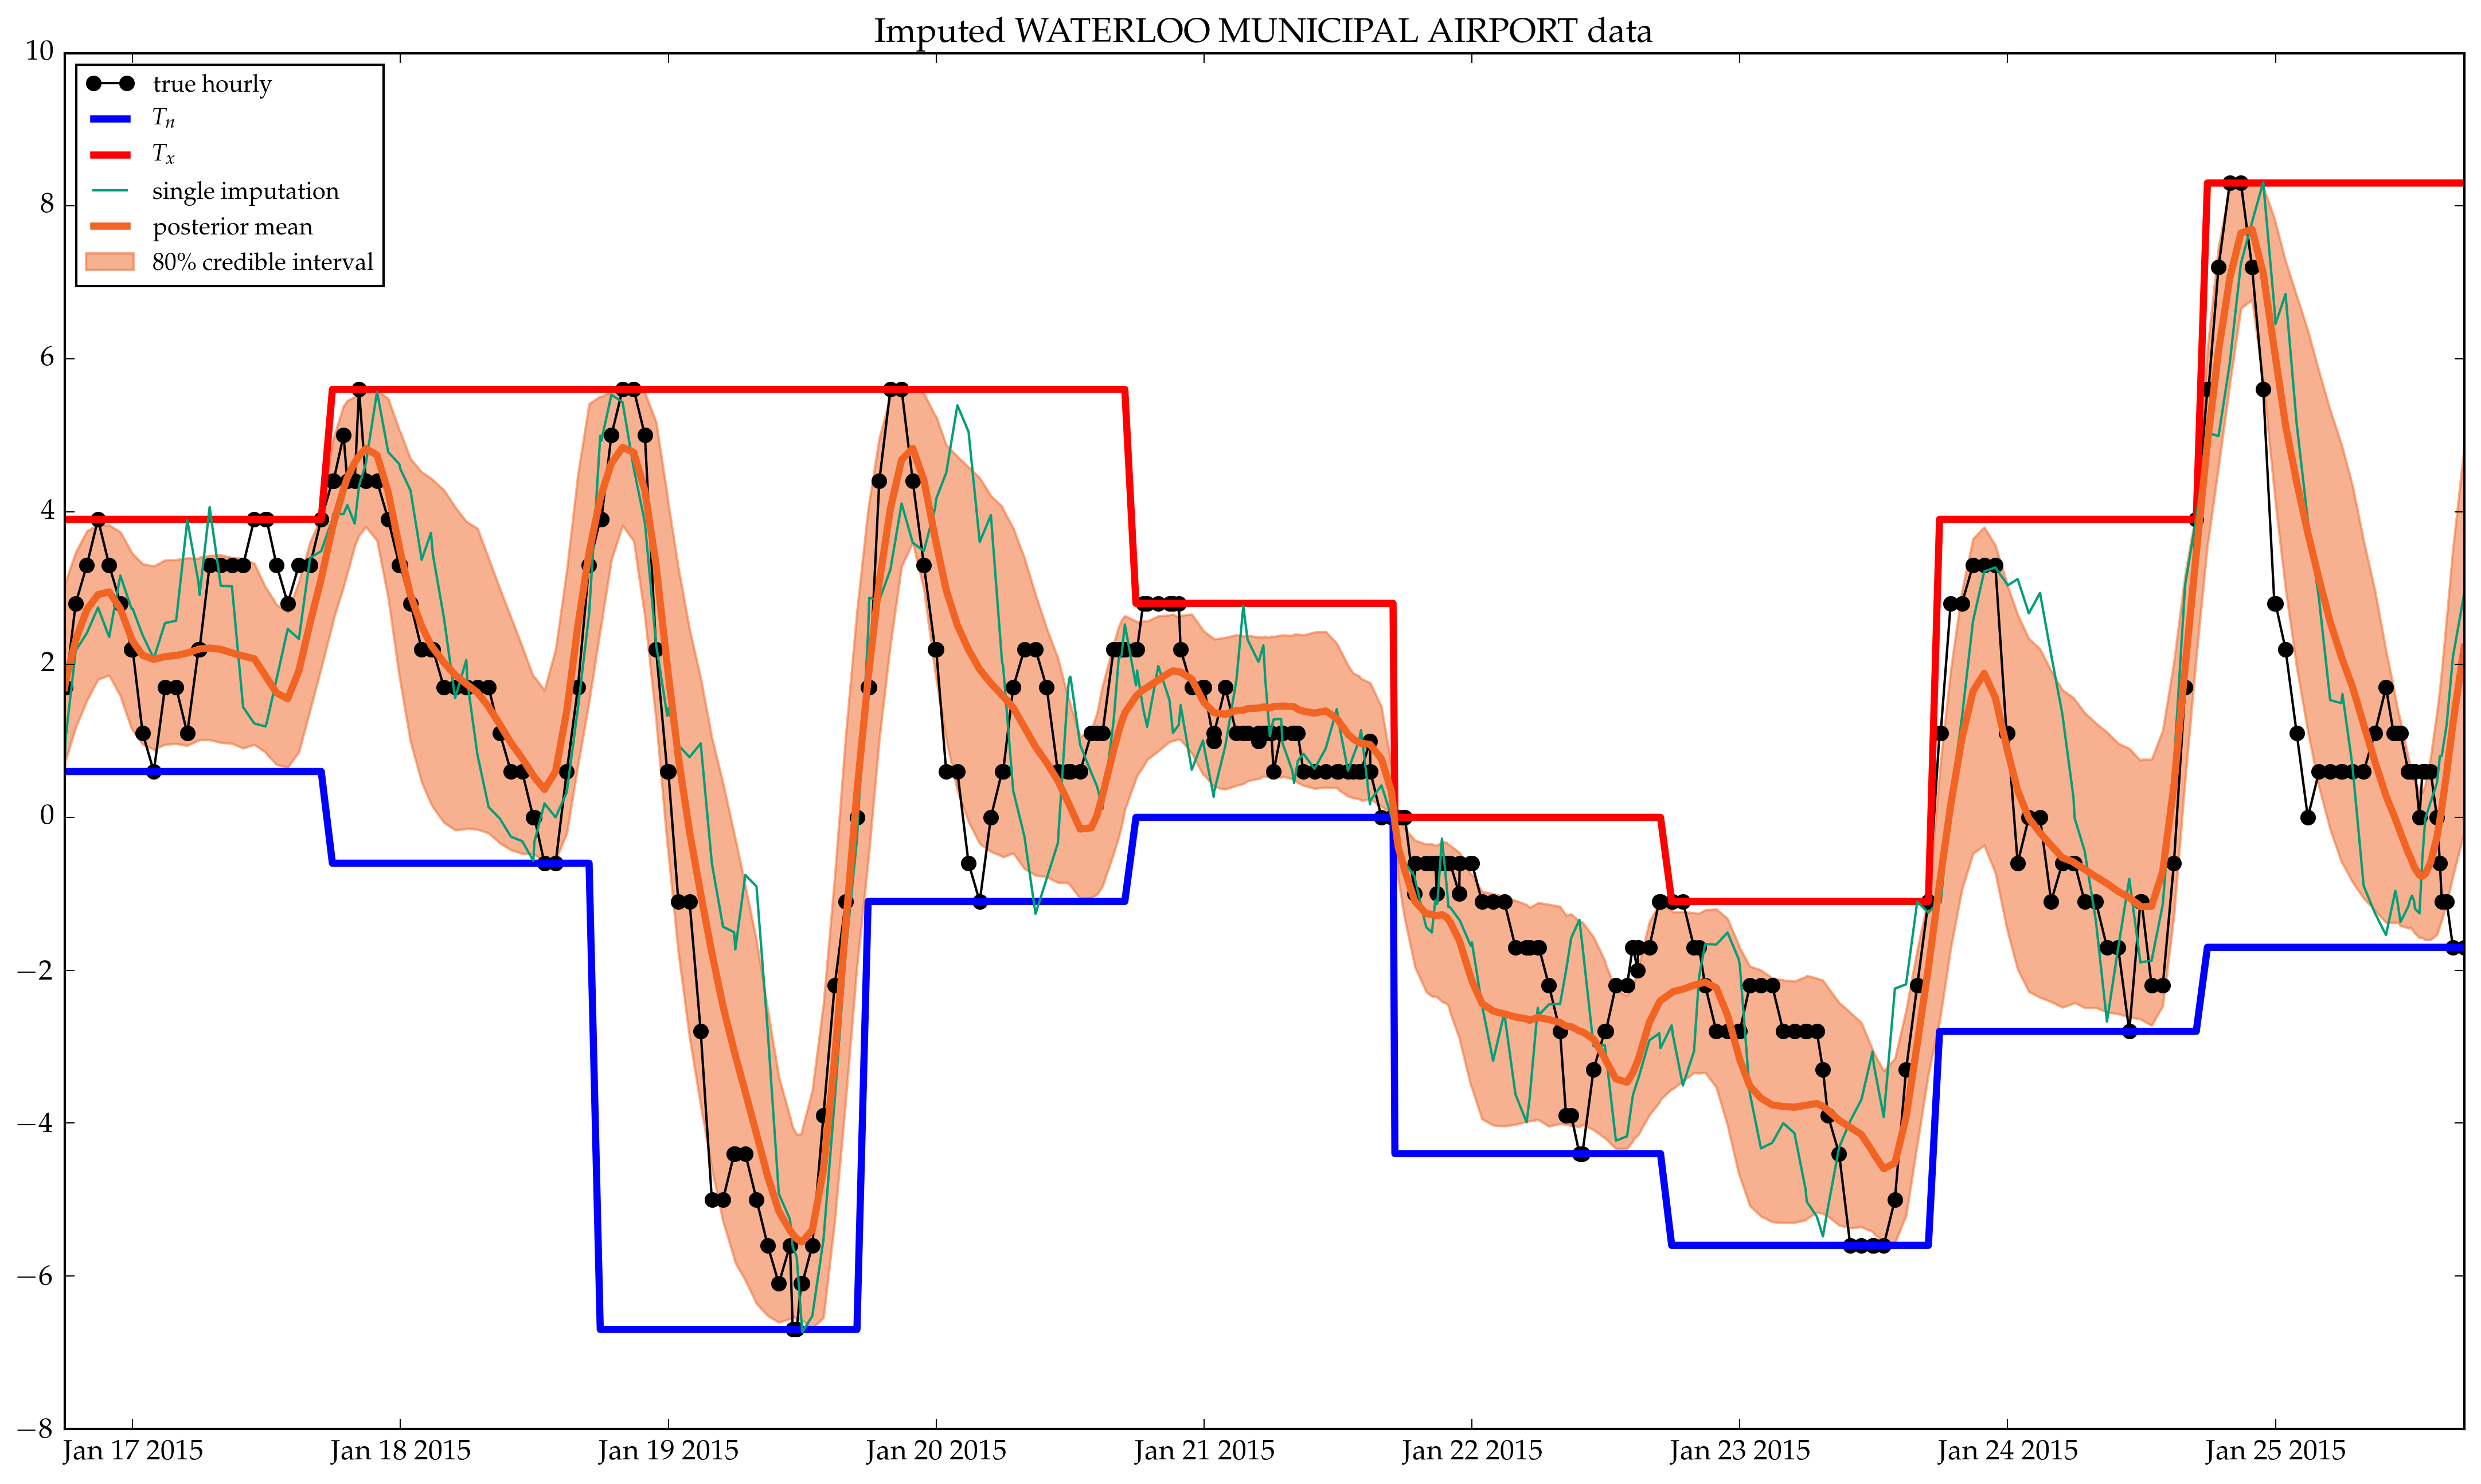

In [82]:
GPModel = "fixed_var"
window_num = 6
stan_fw = get_window(window_num)
chains = get_chains(stan_fw, GPModel)
temp_impute = get_temperatures_reparam(chains)
test_subsubset = get_test_fw(test_trimmed, stan_fw)

plot_truth(test_subsubset)
plot_imputations(test_subsubset[:ts].values, temp_impute)

plt.legend(loc="best", fontsize="small")
plt.gcf()[:set_size_inches](18.0, 10.0)
plt.title(@sprintf("Imputed %s data", get(isdSubset[itest,:NAME])))
;

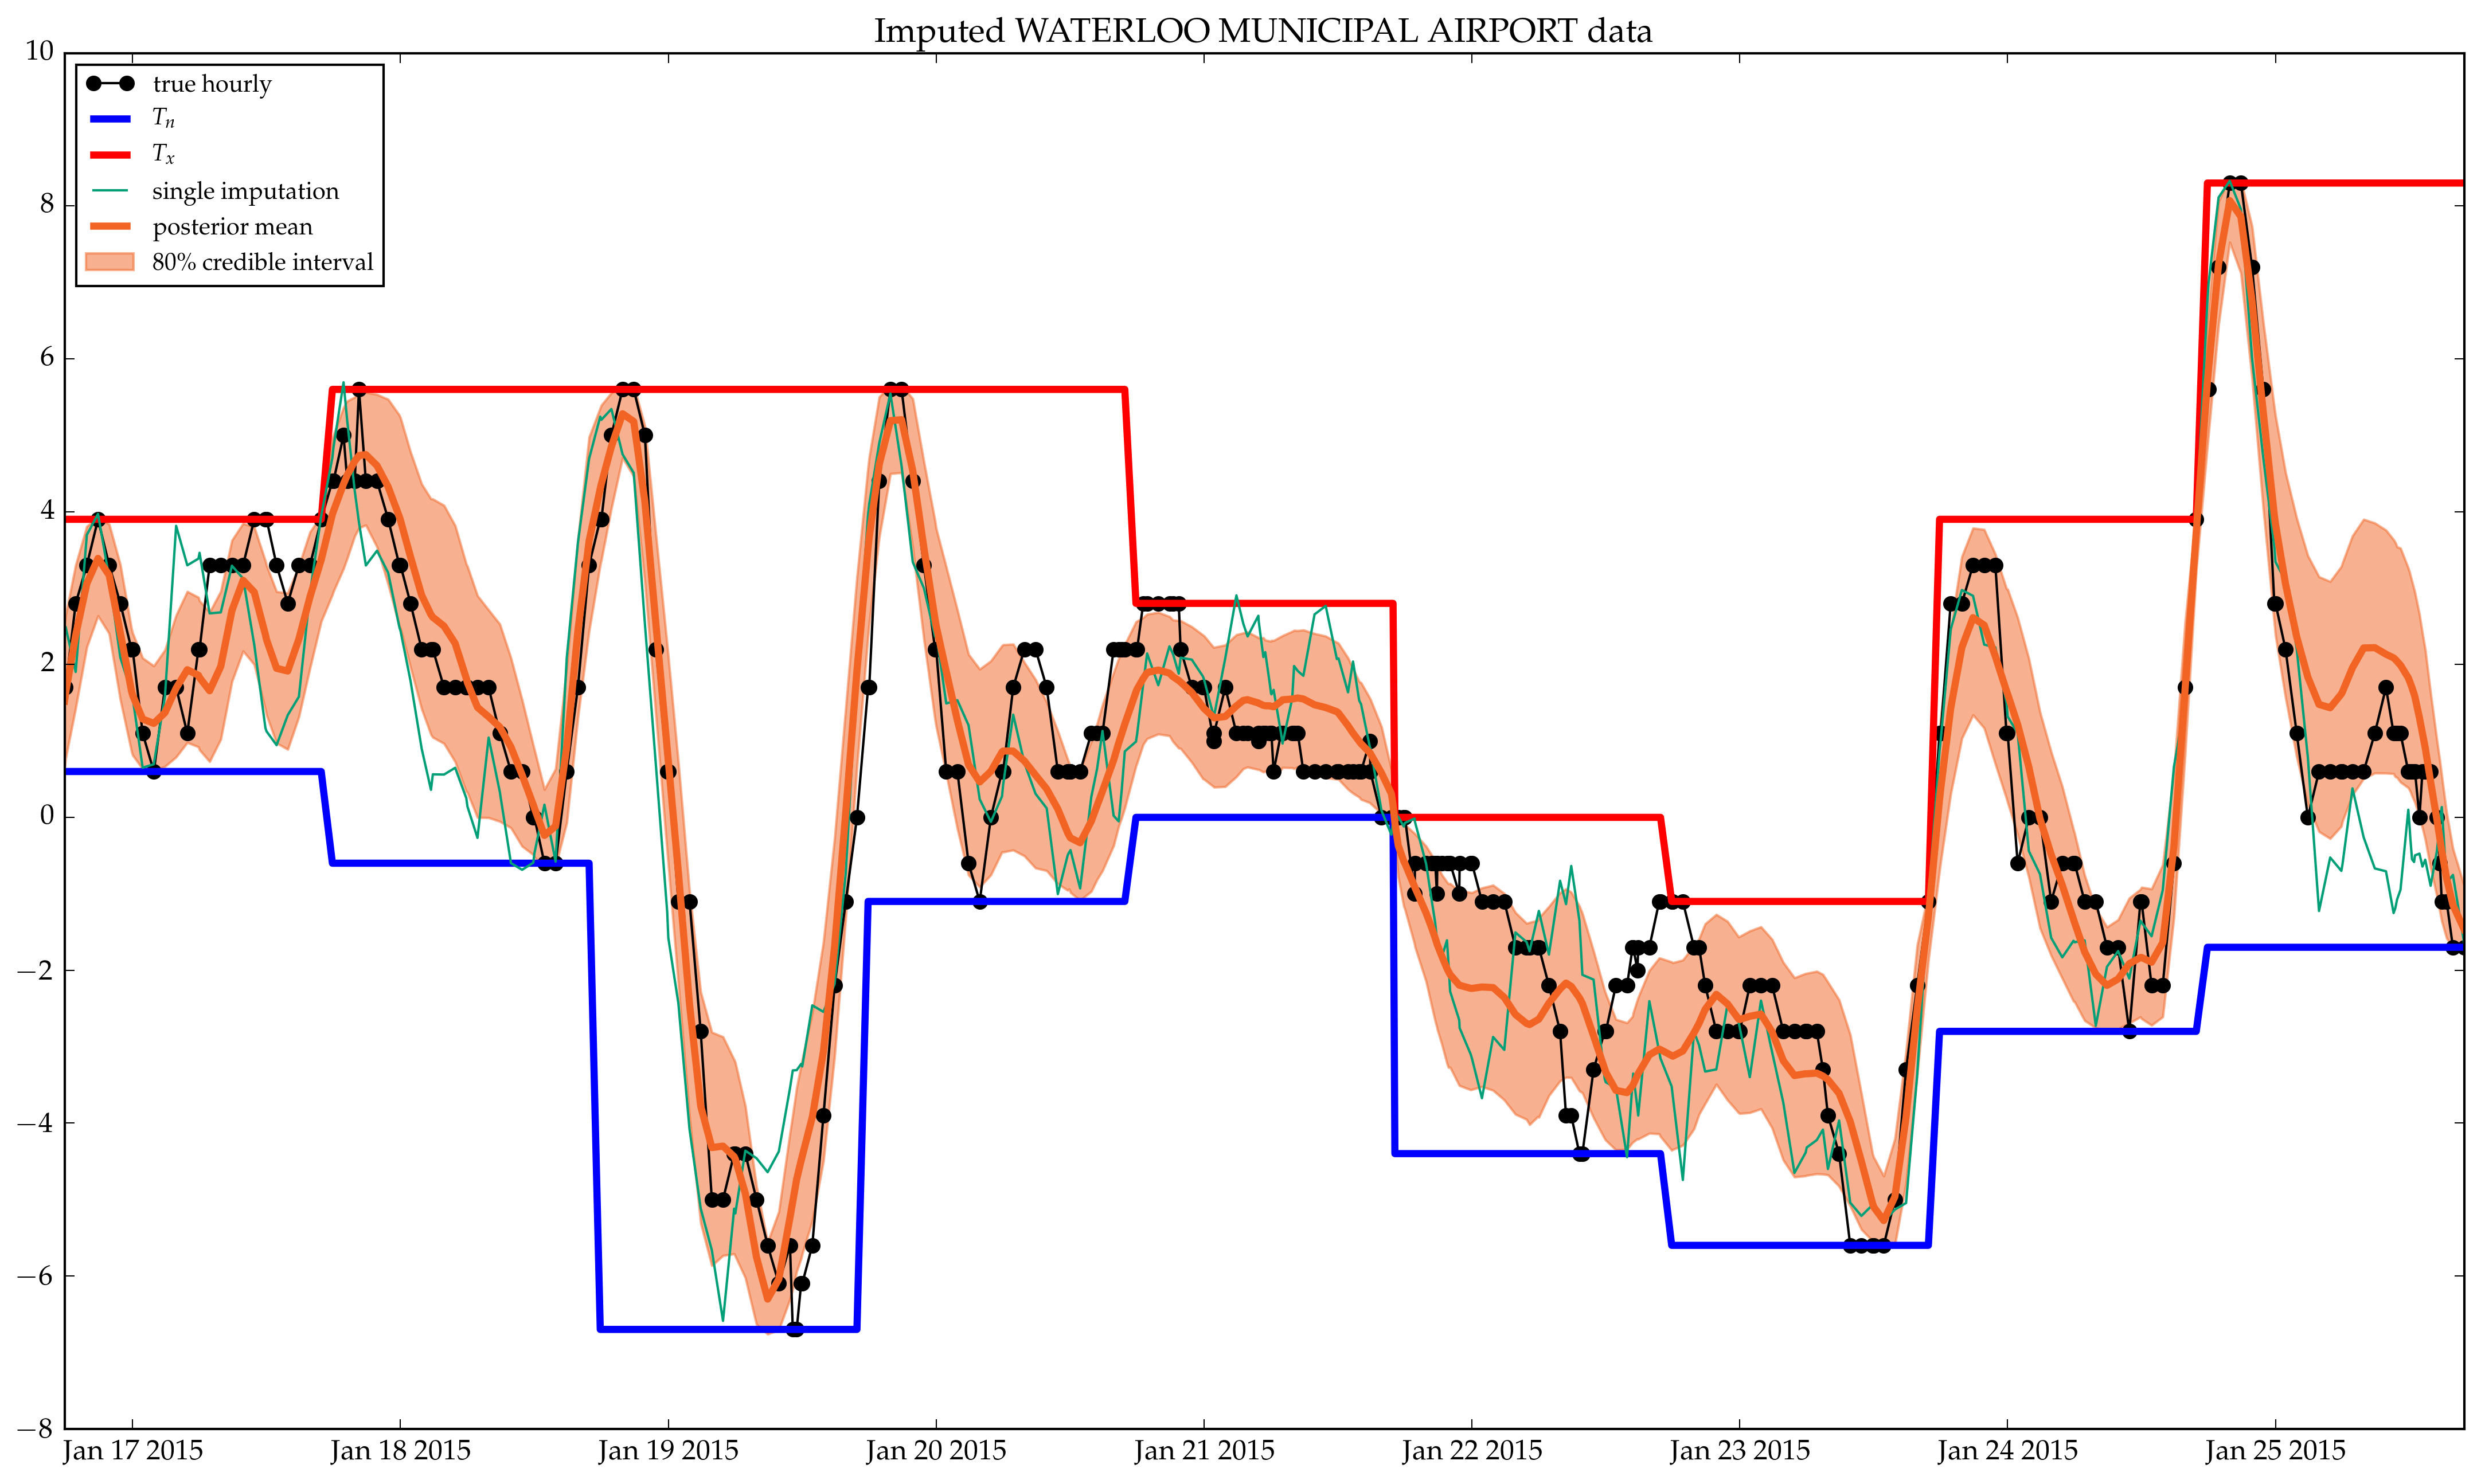

In [83]:
GPModel = "free_var"
window_num = 6
stan_fw = get_window(window_num)
chains = get_chains(stan_fw, GPModel)
temp_impute = get_temperatures_reparam(chains)
test_subsubset = get_test_fw(test_trimmed, stan_fw)

plot_truth(test_subsubset)
plot_imputations(test_subsubset[:ts].values, temp_impute)

plt.legend(loc="best", fontsize="small")
plt.gcf()[:set_size_inches](18.0, 10.0)
plt.title(@sprintf("Imputed %s data", get(isdSubset[itest,:NAME])))
;

In [84]:
mse(yhat::Vector,y::Vector) = mean((y.-yhat).^2)
verr(yhat::Vector,y::Vector) = var(y.-yhat)
type ImputationDiagnostic
    sumEVarError::Float64
    sumSE::Float64
    n::Int
end
EVarError(diag::ImputationDiagnostic) = diag.sumEVarError / diag.n
mse(diag::ImputationDiagnostic) = diag.sumSE / diag.n
function ImputationDiagnostic(temp_impute::Array{Float64,3}, test_truth::DataFrame)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    temp_true = test_truth[:temp].values
    ts = test_subsubset[:ts].values
    μ = vec(mean(stacked_impute, 1))
    evar_err = mean(mse(μ, stacked_impute[i,:]) for i in 1:size(stacked_impute,1))
    MSE = mse(μ, temp_true)
    n = length(μ)
    return ImputationDiagnostic(evar_err*n, MSE*n, n)
end

ImputationDiagnostic

In [89]:
import Base.+
function +(diag1::ImputationDiagnostic,diag2::ImputationDiagnostic)
    return ImputationDiagnostic(
        diag1.sumEVarError + diag2.sumEVarError,
        diag1.sumSE + diag2.sumSE,
        diag1.n + diag2.n
        )
end

+ (generic function with 285 methods)

In [90]:
begin
    temp_impute = get_temperatures_reparam(chains)
    diag += ImputationDiagnostic(temp_impute, test_subsubset)
    @printf("E(var(predicted mean - predictive draw))=%.5f\n", EVarError(diag))
    @printf("MSE(truth - predicted mean)=             %.5f\n", mse(diag))
end

E(var(predicted mean - predictive draw))=0.73031
MSE(truth - predicted mean)=             0.64068


# Aggregating MSE over all windows

In [96]:
GPModel = "fixed_var"
diag = ImputationDiagnostic(0.0,0.0,0)
for window_num in 1:150
    stan_fw = get_window(window_num)
    center_fw = window_center(stan_fw, stan_increment)
    try
        chains = get_chains(stan_fw, GPModel)
    catch
        break
    end
    temp_impute = get_temperatures_reparam(chains)
    test_stan_fw = get_test_fw(test_trimmed, stan_fw)
    arg_center_fw = arg_test_fw(test_stan_fw, center_fw)
    test_center_fw = get_test_fw(test_stan_fw, center_fw)
    temp_impute_center = temp_impute[:,arg_center_fw,:]
    diag += ImputationDiagnostic(temp_impute_center, test_center_fw)
    @printf("E(var(predicted mean - predictive draw))=%.5f\n", EVarError(diag))
    @printf("MSE(truth - predicted mean)=             %.5f\n", mse(diag))
end

E(var(predicted mean - predictive draw))=2.84656
MSE(truth - predicted mean)=             8.15602
E(var(predicted mean - predictive draw))=2.61485
MSE(truth - predicted mean)=             4.93592
E(var(predicted mean - predictive draw))=3.15612
MSE(truth - predicted mean)=             6.63969
E(var(predicted mean - predictive draw))=3.21360
MSE(truth - predicted mean)=             6.57060
E(var(predicted mean - predictive draw))=2.94334
MSE(truth - predicted mean)=             5.61845
E(var(predicted mean - predictive draw))=2.55253
MSE(truth - predicted mean)=             4.72162
E(var(predicted mean - predictive draw))=2.42265
MSE(truth - predicted mean)=             4.32223
E(var(predicted mean - predictive draw))=2.25567
MSE(truth - predicted mean)=             3.87774
E(var(predicted mean - predictive draw))=2.23196
MSE(truth - predicted mean)=             3.64860
E(var(predicted mean - predictive draw))=2.24239
MSE(truth - predicted mean)=             3.72728
E(var(predicted mean

In [95]:
GPModel = "free_var"
diag = ImputationDiagnostic(0.0,0.0,0)
for window_num in 1:150
    stan_fw = get_window(window_num)
    center_fw = window_center(stan_fw, stan_increment)
    try
        chains = get_chains(stan_fw, GPModel)
    catch
        break
    end
    temp_impute = get_temperatures_reparam(chains)
    test_stan_fw = get_test_fw(test_trimmed, stan_fw)
    arg_center_fw = arg_test_fw(test_stan_fw, center_fw)
    test_center_fw = get_test_fw(test_stan_fw, center_fw)
    temp_impute_center = temp_impute[:,arg_center_fw,:]
    diag += ImputationDiagnostic(temp_impute_center, test_center_fw)
    @printf("E(var(predicted mean - predictive draw))=%.5f\n", EVarError(diag))
    @printf("MSE(truth - predicted mean)=             %.5f\n", mse(diag))
end

E(var(predicted mean - predictive draw))=0.83786
MSE(truth - predicted mean)=             2.07703
E(var(predicted mean - predictive draw))=0.82975
MSE(truth - predicted mean)=             1.12634
E(var(predicted mean - predictive draw))=0.85241
MSE(truth - predicted mean)=             1.26184
E(var(predicted mean - predictive draw))=0.89207
MSE(truth - predicted mean)=             1.60660
E(var(predicted mean - predictive draw))=0.86314
MSE(truth - predicted mean)=             1.43161
E(var(predicted mean - predictive draw))=0.81029
MSE(truth - predicted mean)=             1.34069
E(var(predicted mean - predictive draw))=0.81552
MSE(truth - predicted mean)=             1.26747
E(var(predicted mean - predictive draw))=0.79367
MSE(truth - predicted mean)=             1.21681
E(var(predicted mean - predictive draw))=0.79995
MSE(truth - predicted mean)=             1.16878
E(var(predicted mean - predictive draw))=0.84147
MSE(truth - predicted mean)=             1.14240
E(var(predicted mean

In [93]:
GPModel = "sumprod"
diag = ImputationDiagnostic(0.0,0.0,0)
for window_num in 1:150
    stan_fw = get_window(window_num)
    center_fw = window_center(stan_fw, stan_increment)
    try
        chains = get_chains(stan_fw, GPModel)
    catch
        break
    end
    temp_impute = get_temperatures_reparam(chains)
    test_stan_fw = get_test_fw(test_trimmed, stan_fw)
    arg_center_fw = arg_test_fw(test_stan_fw, center_fw)
    test_center_fw = get_test_fw(test_stan_fw, center_fw)
    temp_impute_center = temp_impute[:,arg_center_fw,:]
    diag += ImputationDiagnostic(temp_impute_center, test_center_fw)
    @printf("E(var(predicted mean - predictive draw))=%.5f\n", EVarError(diag))
    @printf("MSE(truth - predicted mean)=             %.5f\n", mse(diag))
end

E(var(predicted mean - predictive draw))=0.97638
MSE(truth - predicted mean)=             1.85468
E(var(predicted mean - predictive draw))=0.91328
MSE(truth - predicted mean)=             0.98912
E(var(predicted mean - predictive draw))=0.93406
MSE(truth - predicted mean)=             1.14960
E(var(predicted mean - predictive draw))=0.97935
MSE(truth - predicted mean)=             1.45777
E(var(predicted mean - predictive draw))=0.94538
MSE(truth - predicted mean)=             1.29230
E(var(predicted mean - predictive draw))=0.87848
MSE(truth - predicted mean)=             1.19753
E(var(predicted mean - predictive draw))=0.87762
MSE(truth - predicted mean)=             1.12027
E(var(predicted mean - predictive draw))=0.84957
MSE(truth - predicted mean)=             1.05383
E(var(predicted mean - predictive draw))=0.85045
MSE(truth - predicted mean)=             1.01674
E(var(predicted mean - predictive draw))=0.88343
MSE(truth - predicted mean)=             1.00031
E(var(predicted mean

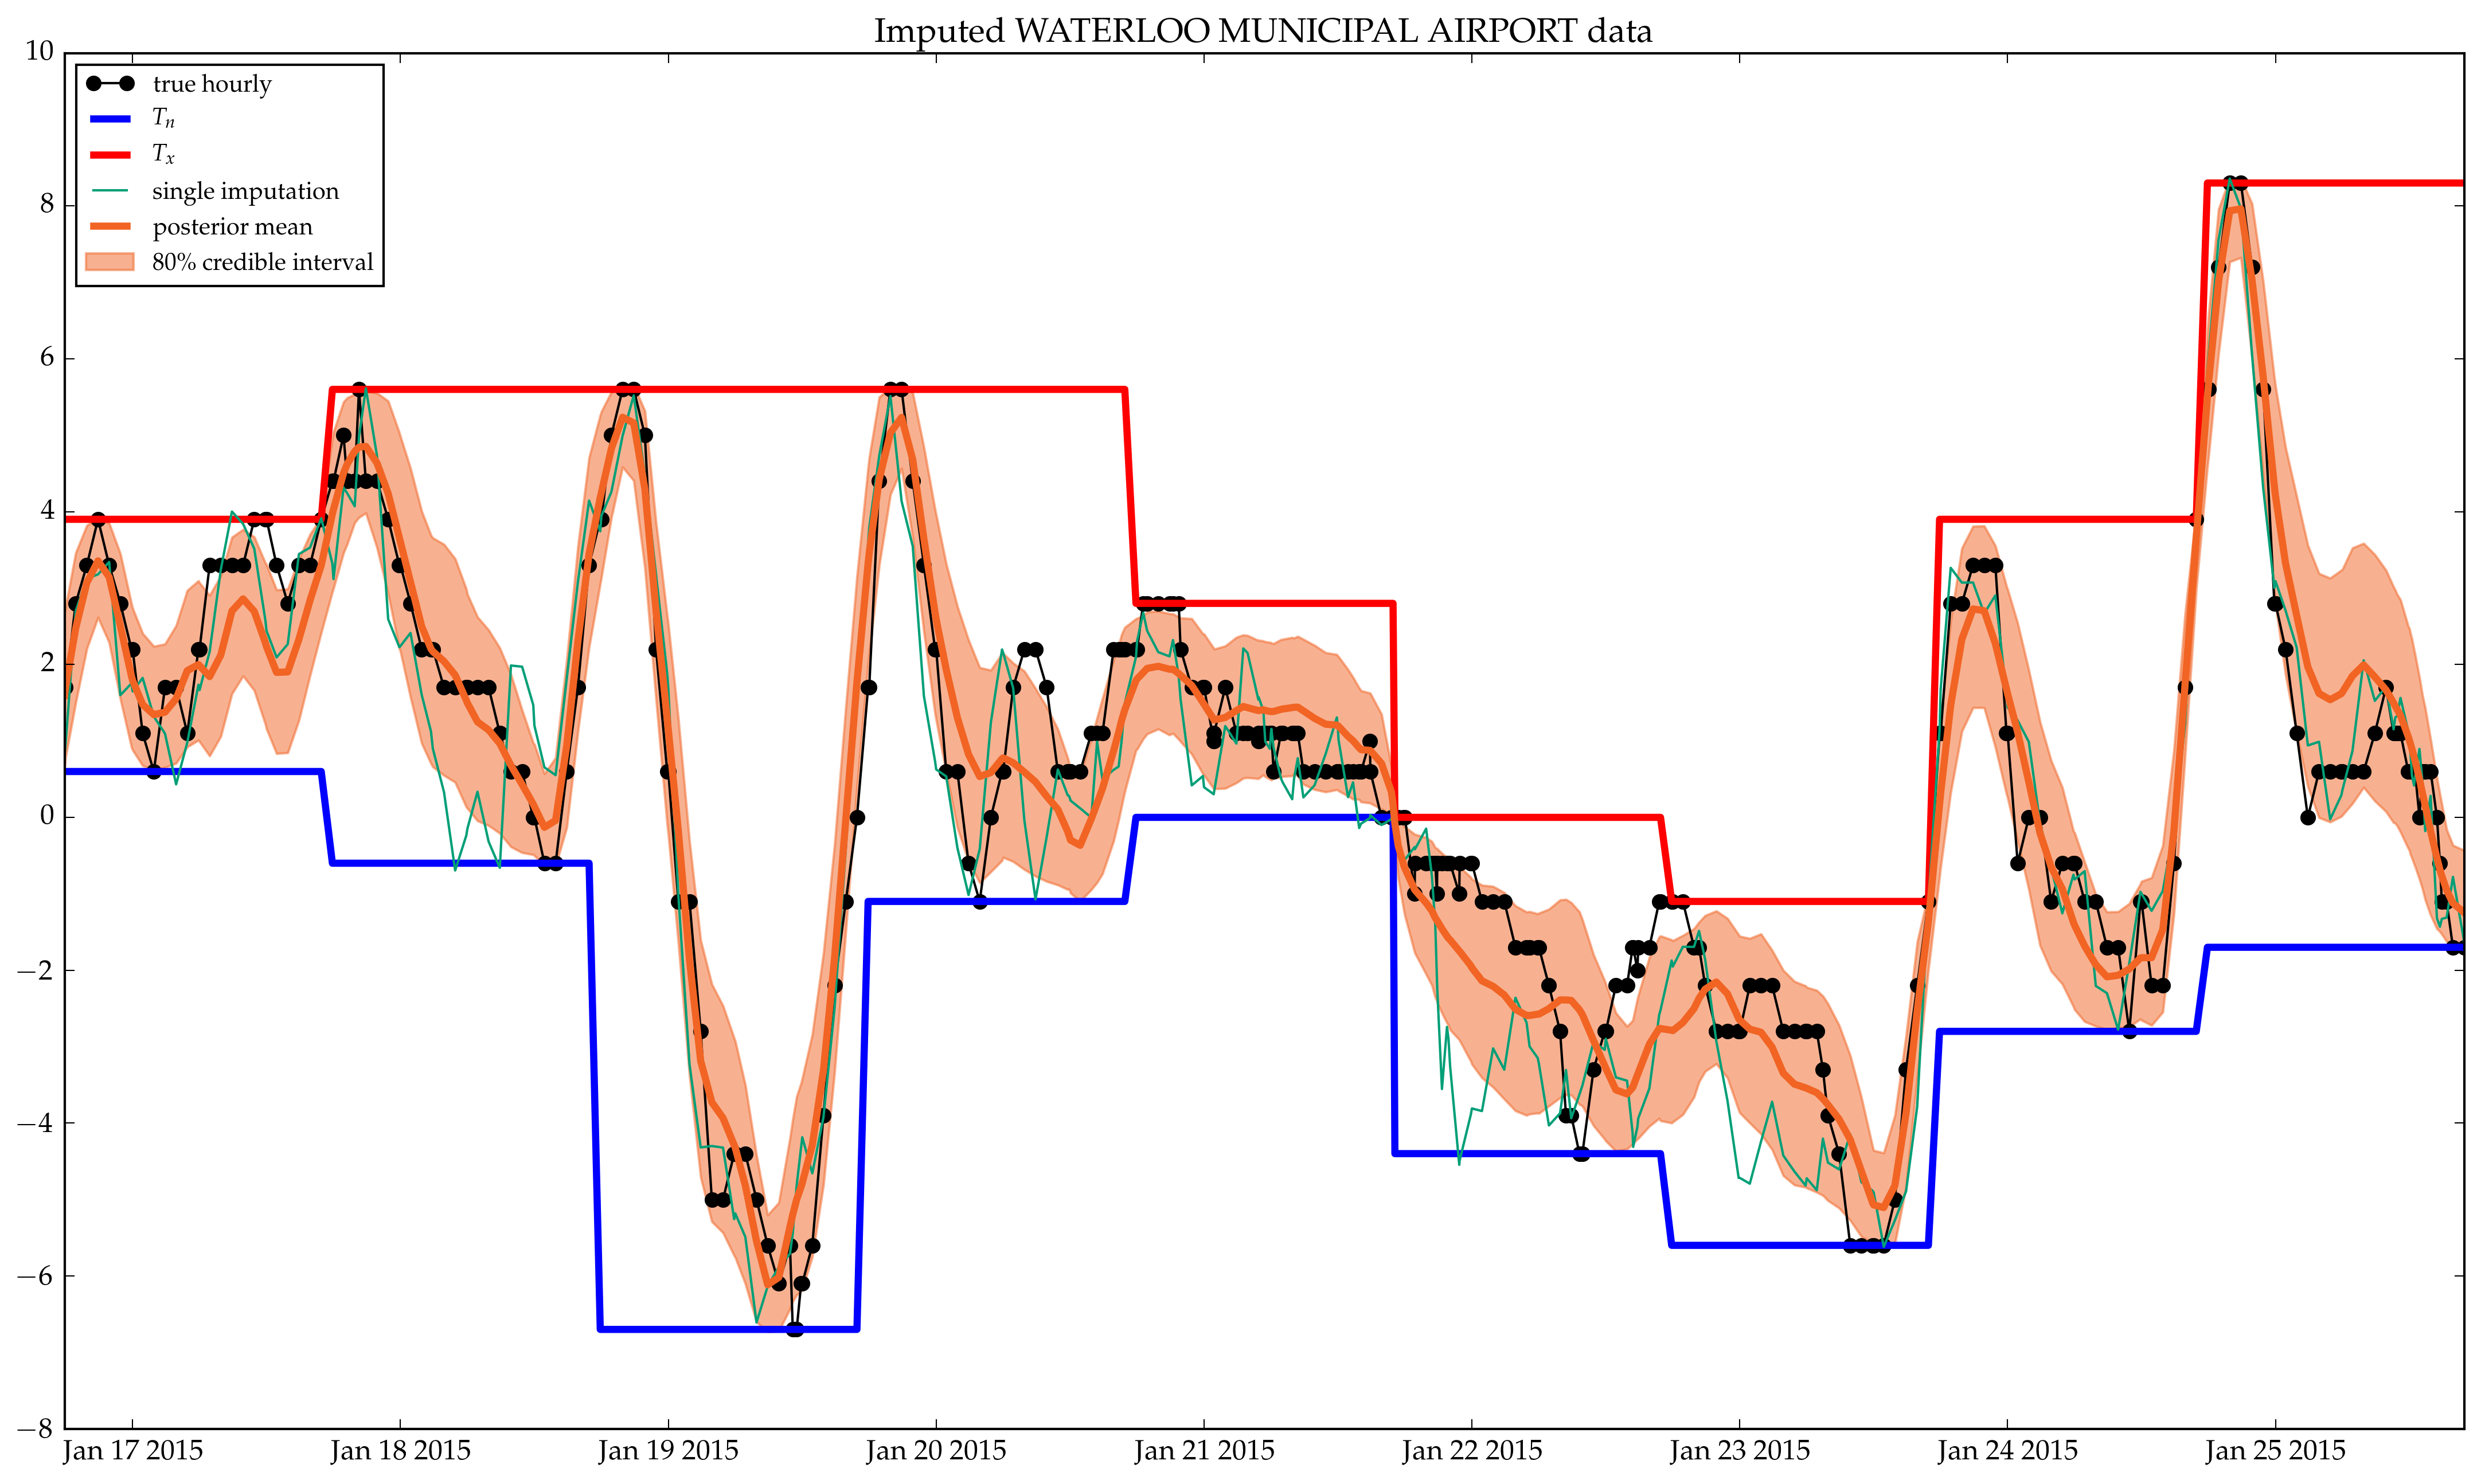

In [88]:
GPModel = "sumprod"
window_num = 6
stan_fw = get_window(window_num)
chains = get_chains(stan_fw, GPModel)
temp_impute = get_temperatures_reparam(chains)
test_subsubset = get_test_fw(test_trimmed, stan_fw)

plot_truth(test_subsubset)
plot_imputations(test_subsubset[:ts].values, temp_impute)

plt.legend(loc="best", fontsize="small")
plt.gcf()[:set_size_inches](18.0, 10.0)
plt.title(@sprintf("Imputed %s data", get(isdSubset[itest,:NAME])))
;

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Fixed-variances" data-toc-modified-id="Fixed-variances-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fixed variances</a></div><div class="lev1 toc-item"><a href="#Sum-of-products,-freed-variances" data-toc-modified-id="Sum-of-products,-freed-variances-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sum of products, freed variances</a></div><div class="lev1 toc-item"><a href="#Sum-of-products,-all-parameters-free" data-toc-modified-id="Sum-of-products,-all-parameters-free-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sum of products, all parameters free</a></div><div class="lev1 toc-item"><a href="#STAN-Imputations" data-toc-modified-id="STAN-Imputations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>STAN Imputations</a></div>